<a href="https://colab.research.google.com/github/harnalashok/timeseries/blob/main/tsfresh_Timeseries_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# LAst amended: 16th Feb, 2023
# Objectives:
#             a) Using tsfresh
#             b) Forecasting univariate time series data
# Ref:
#  https://github.com/blue-yonder/tsfresh/tree/main/notebooks
#  https://github.com/blue-yonder/tsfresh/blob/main/notebooks/05%20Timeseries%20Forecasting.ipynb

# Timeseries Forecasting

This notebook explains how to use `tsfresh` in time series foreacasting.
Make sure you also read through the [documentation](https://tsfresh.readthedocs.io/en/latest/text/forecasting.html) to learn more on this feature.

We will use the stock price of Apple for this.
In this notebook we will only showcase how to work with a single time series at a time (one stock).
There exist another notebook in the `advanced` folder, which treats several stocks at the same time.
Basically the same - but a bit more complex when it comes to pandas multi-indexing.

## Install tsfresh

In [1]:
!pip install tsfresh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Up-to-date remote data access for pandas. 
! pip install pandas_datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Call libraries

In [3]:
# 1.0
%matplotlib inline
import matplotlib.pylab as plt

# 1.0.1
import numpy as np
import pandas as pd

# 1.0.2
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import roll_time_series, make_forecasting_frame
from tsfresh.utilities.dataframe_functions import impute

# 1.0.3 Read data from Internet
import pandas_datareader.data as web

# 1.0.4
from sklearn.linear_model import LinearRegression

ERROR:numba.cuda.cudadrv.driver:Call to cuInit results in CUDA_ERROR_NO_DEVICE


In [4]:
# 1.1.0
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Reading the data

Functions from `pandas_datareader.data` and `pandas_datareader.wb` extract data from various Internet sources into a pandas DataFrame. Currently a number of Internet sources are supported. See [here](https://pydata.github.io/pandas-datareader/remote_data.html#remote-data-stooq) for a list.

We download the index data from `"stooq"` site and only store the `'High'` value.

In [5]:
# 2.0 Here is help on web.DataReader:

help(web.DataReader)

Help on function DataReader in module pandas_datareader.data:

DataReader(name, data_source=None, start=None, end=None, retry_count=3, pause=0.1, session=None, api_key=None)
    Imports data from a number of online sources.
    
    Currently supports Google Finance, St. Louis FED (FRED),
    and Kenneth French's data library, among others.
    
    Parameters
    ----------
    name : str or list of strs
        the name of the dataset. Some data sources (IEX, fred) will
        accept a list of names.
    data_source: {str, None}
        the data source ("iex", "fred", "ff")
    start : string, int, date, datetime, Timestamp
        left boundary for range (defaults to 1/1/2010)
    end : string, int, date, datetime, Timestamp
        right boundary for range (defaults to today)
    retry_count : {int, 3}
        Number of times to retry query request.
    pause : {numeric, 0.001}
        Time, in seconds, to pause between consecutive queries of chunks. If
        single value given 

In [6]:
# 2.1 Extract index data from 'stooq' site as pandas DataFrame
#     We will later retain only 'High' column:

df = web.DataReader("AAPL", 'stooq')
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2023-02-15,153.110,155.5000,152.88,155.33,65669252.0
2023-02-14,152.120,153.7700,150.86,153.20,61707573.0
2023-02-13,150.952,154.2600,150.92,153.85,62199013.0
2023-02-10,149.460,151.3401,149.22,151.01,57450708.0
2023-02-09,153.775,154.3300,150.42,150.87,56007143.0


In [7]:
# 2.2
df.shape   # (1257,) 

(1257, 5)

In [8]:
# 2.3
# Date index is in Descending order
# Current date first.
df.head()
print("\n---Data starts from 20-02-2018----\n")
df.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2023-02-15,153.110,155.5000,152.88,155.33,65669252.0
2023-02-14,152.120,153.7700,150.86,153.20,61707573.0
2023-02-13,150.952,154.2600,150.92,153.85,62199013.0
2023-02-10,149.460,151.3401,149.22,151.01,57450708.0
2023-02-09,153.775,154.3300,150.42,150.87,56007143.0



---Data starts from 20-02-2018----



,Open,High,Low,Close,Volume
Date,,,,,
2018-02-26,42.0926,42.8204,42.0597,42.7197,1.586169e+08
2018-02-23,41.4515,41.9281,41.4217,41.8942,1.415387e+08
2018-02-22,41.0069,41.5193,40.9850,41.1754,1.296853e+08
2018-02-21,41.2542,41.5583,40.8165,40.8305,1.566260e+08
2018-02-20,41.0668,41.5931,40.9162,41.0189,1.420001e+08


<Figure size 1080x432 with 0 Axes>

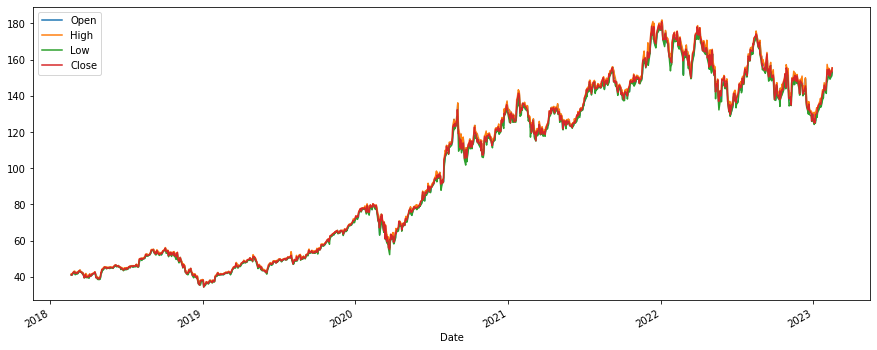

In [9]:
# 3.0 Plot dataframe
plt.figure(figsize=(15, 6))
# df.plot()  
df.iloc[:,:-1].plot(ax = plt.gca())
plt.show()

In [10]:
# 3.1 Retail just 'High':
df = df[['High']]
df.head()

,High
Date,
2023-02-15,155.5000
2023-02-14,153.7700
2023-02-13,154.2600
2023-02-10,151.3401
2023-02-09,154.3300


We want to make the time dependency a bit clearer and add an identifier to each of the stock values (in this notebook we only have Google though).

In [11]:
# 4.0
df_melted = df.copy()
df_melted.rename(columns = {'High' : 'high'}, inplace = True)
df_melted["date"] = df_melted.index
df_melted["Symbols"] = "AAPL"
df_melted.head()

,high,date,Symbols
Date,,,
2023-02-15,155.5000,2023-02-15,AAPL
2023-02-14,153.7700,2023-02-14,AAPL
2023-02-13,154.2600,2023-02-13,AAPL
2023-02-10,151.3401,2023-02-10,AAPL
2023-02-09,154.3300,2023-02-09,AAPL


## Create training data sample

Forecasting typically involves the following steps:
* take all data up to today
* do feature extraction (e.g. by running `extract_features`)
* run a prediction model (e.g. a regressor, see below)
* use the result as the forecast for tomorrow

In training however, we need multiple examples to train.
If we would only use the time series until today (and wait for the value of tomorrow to have a target), we would only have a single training example.
Therefore we use a trick: we replay the history.

Imagine you have a cut-out window sliding over your data.
At each time step $t$, you treat the data as it would be today. 
You extract the features with everything you know until today (which is all data until and including $t$).
The target for the features until time $t$ is the time value of time $t + 1$ (which you already know, because everything has already happened).

The process of window-sliding is implemented in the function `roll_time_series`.
Our window size will be 20 (we look at max 20 days in the past) and we disregard all windows which are shorter than 5 days.

In [12]:
# 5.0
help(roll_time_series)

Help on function roll_time_series in module tsfresh.utilities.dataframe_functions:

roll_time_series(df_or_dict, column_id, column_sort=None, column_kind=None, rolling_direction=1, max_timeshift=None, min_timeshift=0, chunksize=None, n_jobs=1, show_warnings=False, disable_progressbar=False, distributor=None)
    This method creates sub windows of the time series. It rolls the (sorted) data frames for each kind and each id
    separately in the "time" domain (which is represented by the sort order of the sort column given by `column_sort`).
    
    For each rolling step, a new id is created by the scheme ({id}, {shift}), here id is the former id of
    the column and shift is the amount of "time" shifts.
    You can think of it as having a window of fixed length (the max_timeshift) moving one step at a time over
    your time series.
    Each cut-out seen by the window is a new time series with a new identifier.
    
    A few remarks:
    
     * This method will create new IDs!
     

### Demo of rolling timeseries

In [13]:
# 5.1 Sample data
dx = pd.DataFrame(
                    {
                      "id": [1, 1, 1, 1, 2, 2],
                    "time": [1, 2, 3, 4, 8, 9],
                      "x": [1, 2, 3, 4, 10, 11],
                      "y": [5, 6, 7, 8, 12, 13],
                    }
                  )

dx

,id,time,x,y
0,1,1,1,5
1,1,2,2,6
2,1,3,3,7
3,1,4,4,8
4,2,8,10,12
5,2,9,11,13


Rolling window could be thought of having a window sliding over the time series data and extracting out every data you can see through this window. There are three parameters to consider while sliding:

>`max_timeshift`: It defines, how large the window would be at maximum. The extracted time series will have at maximum length of `max_timeshift + 1`. (they can also be smaller, as time stamps in the beginning have less past values).<br>

>`min_timeshift` defines the minimal size of each window. Shorter time series (usually at the beginning) will be omitted.<br>

>`rolling_direction`: if you want to slide in positive (increasing sort) or negative (decreasing sort) direction. You barely need negative direction, so you probably do not want to change the default. The absolute value of this parameter decides how much you want to shift per cut-out step.<br>

So the generated time series for the following code would be as below:<br>
<pre>
df_rolled = roll_time_series(df,
                             column_id="id",
                             column_sort="time"
                             )
</pre>


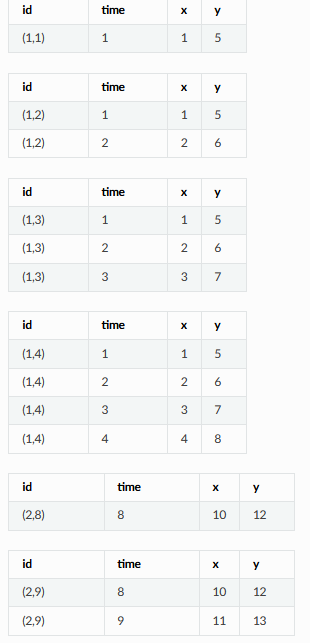

In [14]:
# 5.2 Get rolling window dataframe:
df_rolled = roll_time_series(dx,
                             column_id="id",
                             column_sort="time"
                             )

Rolling: 100%|██████████| 4/4 [00:00<00:00, 316.72it/s]


In [15]:
# 5.3 Dataframe after rolling window is:
df_rolled

,id,time,x,y
0,"(1, 1)",1,1,5
2,"(1, 2)",1,1,5
3,"(1, 2)",2,2,6
6,"(1, 3)",1,1,5
7,"(1, 3)",2,2,6
8,"(1, 3)",3,3,7
9,"(1, 4)",1,1,5
10,"(1, 4)",2,2,6
11,"(1, 4)",3,3,7
12,"(1, 4)",4,4,8


### Our data

In [16]:
# 6.0 
df_rolled = roll_time_series(
                             df_melted,
                             column_id="Symbols",
                             column_sort="date",
                             max_timeshift=20,
                             min_timeshift=5
                             )

/usr/local/lib/python3.8/dist-packages/tsfresh/utilities/dataframe_functions.py:520: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn(
Rolling: 100%|██████████| 1257/1257 [00:04<00:00, 275.56it/s]


In [17]:
# 6.1 Here is our new dataframe:

df_rolled.head()

,high,date,Symbols,id
0,41.5931,2018-02-20,AAPL,"(AAPL, 2018-02-27 00:00:00)"
1,41.5583,2018-02-21,AAPL,"(AAPL, 2018-02-27 00:00:00)"
2,41.5193,2018-02-22,AAPL,"(AAPL, 2018-02-27 00:00:00)"
3,41.9281,2018-02-23,AAPL,"(AAPL, 2018-02-27 00:00:00)"
4,42.8204,2018-02-26,AAPL,"(AAPL, 2018-02-27 00:00:00)"


In [18]:
# 6.2 To understand rolling dataframe, 
#       let us look at our orginal dataframe:

df_melted.head(21).sort_values(by = 'date')

,high,date,Symbols
Date,,,
2023-01-18,138.6100,2023-01-18,AAPL
2023-01-19,136.2500,2023-01-19,AAPL
2023-01-20,138.0200,2023-01-20,AAPL
2023-01-23,143.3150,2023-01-23,AAPL
2023-01-24,143.1600,2023-01-24,AAPL
2023-01-25,142.4300,2023-01-25,AAPL
2023-01-26,144.2500,2023-01-26,AAPL
2023-01-27,147.2300,2023-01-27,AAPL
2023-01-30,145.5500,2023-01-30,AAPL


The resulting dataframe now consists of these "windows" stamped out of the original dataframe. Let us examine it. But before that let us have a look once more at our original data:


In [19]:
# 6.3 Last 21 rows of our original data:
df_melted.tail(21)

,high,date,Symbols
Date,,,
2018-03-20,42.1973,2018-03-20,AAPL
2018-03-19,42.3598,2018-03-19,AAPL
2018-03-16,42.7526,2018-03-16,AAPL
2018-03-15,43.0237,2018-03-15,AAPL
2018-03-14,43.0895,2018-03-14,AAPL
2018-03-13,43.8034,2018-03-13,AAPL
2018-03-12,43.5352,2018-03-12,AAPL
2018-03-09,42.9639,2018-03-09,AAPL
2018-03-08,42.2771,2018-03-08,AAPL


In [20]:
# 6.4 Let us look at extracted timeseries for one id when date is  "2018-02-20"
ds = df_rolled[df_rolled["id"] == ("AAPL", pd.to_datetime("2018-02-20"))]
ds.shape   
print("\n============\n")
# Start from bottom and count upwards
#  there are No rows here as minimum is min_timeshift
#    and max is max_timeshift+1:
ds

(0, 4)

,high,date,Symbols,id


In [21]:
# 6.5 Next, let us look at extracted timeseries for one id when date is  "2018-02-27"
ds = df_rolled[df_rolled["id"] == ("AAPL", pd.to_datetime("2018-02-27"))]
ds.shape  # (6, 4)
print("\n============\n")
# Start from bottom and count upwards
#  6 rows here:
ds

(6, 4)

,high,date,Symbols,id
0,41.5931,2018-02-20,AAPL,"(AAPL, 2018-02-27 00:00:00)"
1,41.5583,2018-02-21,AAPL,"(AAPL, 2018-02-27 00:00:00)"
2,41.5193,2018-02-22,AAPL,"(AAPL, 2018-02-27 00:00:00)"
3,41.9281,2018-02-23,AAPL,"(AAPL, 2018-02-27 00:00:00)"
4,42.8204,2018-02-26,AAPL,"(AAPL, 2018-02-27 00:00:00)"
5,43.0836,2018-02-27,AAPL,"(AAPL, 2018-02-27 00:00:00)"


In [22]:
# 6.6
len(df_melted)

1257

we now have 1252 unique windows (identified by stock symbol and ending date):

In [23]:
# 6.7
df_rolled["id"].nunique()

1252

We "lost" 5 windows, as we required to have a minimum history of more than 5 days.

In [24]:
# 6.8
df_rolled.groupby("id").size().agg([np.min, np.max])

amin     6
amax    21
dtype: int64

The process is also shown in this image (please note that the window size is smaller for better visibility):

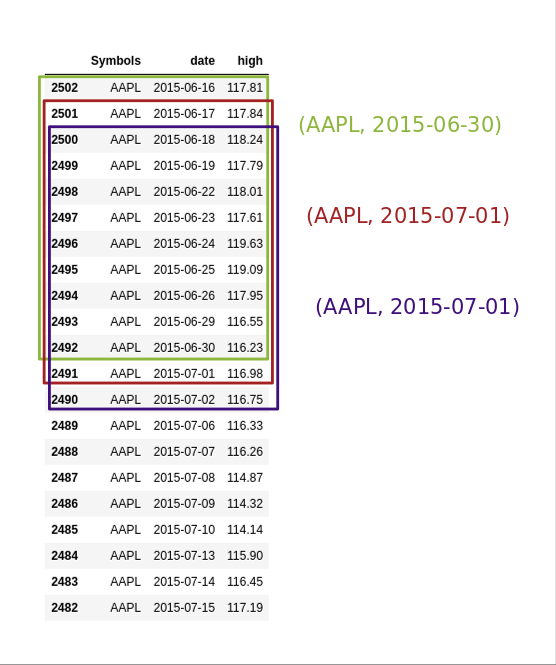

## Extract Features

The rolled (windowed) data sample is now in the correct format to use it for `tsfresh`s feature extraction.
As normal, features will be extracted using all data for a given `id`, which is in our case all data of a given window and a given id (one colored box in the graph above).

If the feature extraction returns a row with the index `(AAPL, 2020-07-14 00:00:00)`, you know it has been calculated using the `AAPL` data up and including `2020-07-14` (and 20 days of history).

For `extract_features()`, see [here](https://tsfresh.readthedocs.io/en/latest/api/tsfresh.feature_extraction.html#tsfresh.feature_extraction.extraction.extract_features)

In [25]:
# 7.0 Extract features now:
X = extract_features(
                     df_rolled.drop("Symbols", axis=1), 
                     column_id="id",
                     column_sort="date",
                     column_value="high", 
                     impute_function=impute,
                     show_warnings=False
                     )

Feature Extraction: 100%|██████████| 1252/1252 [01:08<00:00, 18.16it/s]


In [26]:
# 7.1 Check:
X.shape   # (1252, 783)
print("\n=========\n")
X.head()

(1252, 783)

high__variance_larger_than_standard_deviation  \
AAPL 2018-02-27                                            0.0   
     2018-02-28                                            0.0   
     2018-03-01                                            0.0   
     2018-03-02                                            0.0   
     2018-03-05                                            0.0   

                 high__has_duplicate_max  high__has_duplicate_min  \
AAPL 2018-02-27                      0.0                      0.0   
     2018-02-28                      0.0                      0.0   
     2018-03-01                      0.0                      0.0   
     2018-03-02                      0.0                      0.0   
     2018-03-05                      0.0                      0.0   

                 high__has_duplicate  high__sum_values  high__abs_energy  \
AAPL 2018-02-27                  0.0          252.5028      10628.679354   
     2018-02-28                  0.0          295.6153      12487.367010   
     2018-03-01                  0.0          338.5244      14328.557873   
     2018-03-02                  0.0          380.6051      16099.343185   
     2018-03-05                  0.0          423.0317      17899.359573   

                 high__mean_abs_change  high__mean_change  \
AAPL 2018-02-27               0.327620           0.298100   
     2018-02-28               0.277833           0.253233   
     2018-03-01               0.267200           0.188000   
     2018-03-02               0.337350           0.060950   
     2018-03-05               0.338300           0.092611   

                 high__mean_second_derivative_central  high__median  ...  \
AAPL 2018-02-27                              0.037250      41.76060  ...   
     2018-02-28                              0.006370      41.92810  ...   
     2018-03-01                             -0.014050      42.37425  ...   
     2018-03-02                             -0.056686      42.08070  ...   
     2018-03-05                              0.023794      42.25365  ...   

                 high__fourier_entropy__bins_5  \
AAPL 2018-02-27                       1.039721   
     2018-02-28                       1.039721   
     2018-03-01                       0.950271   
     2018-03-02                       1.054920   
     2018-03-05                       1.011404   

                 high__fourier_entropy__bins_10  \
AAPL 2018-02-27                        1.039721   
     2018-02-28                        1.039721   
     2018-03-01                        0.950271   
     2018-03-02                        1.054920   
     2018-03-05                        1.011404   

                 high__fourier_entropy__bins_100  \
AAPL 2018-02-27                         1.039721   
     2018-02-28                         1.386294   
     2018-03-01                         1.609438   
     2018-03-02                         1.609438   
     2018-03-05                         1.560710   

                 high__permutation_entropy__dimension_3__tau_1  \
AAPL 2018-02-27                                       1.039721   
     2018-02-28                                       0.950271   
     2018-03-01                                       1.242453   
     2018-03-02                                       1.277034   
     2018-03-05                                       1.494175   

                 high__permutation_entropy__dimension_4__tau_1  \
AAPL 2018-02-27                                       1.098612   
     2018-02-28                                       1.039721   
     2018-03-01                                       1.332179   
     2018-03-02                                       1.560710   
     2018-03-05                                       1.747868   

                 high__permutation_entropy__dimension_5__tau_1  \
AAPL 2018-02-27                                       0.693147   
     2018-02-28                                       1.098612   
     2018-0

In [27]:
# 7.2 Note that index is of type tuple
#     We can safely remove 'AAPL' as
#     all dates are unique:
X.index

MultiIndex([('AAPL', '2018-02-27'),
            ('AAPL', '2018-02-28'),
            ('AAPL', '2018-03-01'),
            ('AAPL', '2018-03-02'),
            ('AAPL', '2018-03-05'),
            ('AAPL', '2018-03-06'),
            ('AAPL', '2018-03-07'),
            ('AAPL', '2018-03-08'),
            ('AAPL', '2018-03-09'),
            ('AAPL', '2018-03-12'),
            ...
            ('AAPL', '2023-02-02'),
            ('AAPL', '2023-02-03'),
            ('AAPL', '2023-02-06'),
            ('AAPL', '2023-02-07'),
            ('AAPL', '2023-02-08'),
            ('AAPL', '2023-02-09'),
            ('AAPL', '2023-02-10'),
            ('AAPL', '2023-02-13'),
            ('AAPL', '2023-02-14'),
            ('AAPL', '2023-02-15')],
           length=1252)

We make the data a bit easier to work with by removing the tuple-index

In [28]:
# 7.3 Drop Symbol from index:
X = X.set_index(X.index.map(lambda x: x[1]), drop=True)
X.index.name = "last_date"

Our `(AAPL, 2020-07-14 00:00:00)` is also in the data again:

In [29]:
# 7.4 Index is now one dimension:
X.index

DatetimeIndex(['2018-02-27', '2018-02-28', '2018-03-01', '2018-03-02',
               '2018-03-05', '2018-03-06', '2018-03-07', '2018-03-08',
               '2018-03-09', '2018-03-12',
               ...
               '2023-02-02', '2023-02-03', '2023-02-06', '2023-02-07',
               '2023-02-08', '2023-02-09', '2023-02-10', '2023-02-13',
               '2023-02-14', '2023-02-15'],
              dtype='datetime64[ns]', name='last_date', length=1252, freq=None)

In [30]:
# 7.5 And our data now:
X.head()

,high__variance_larger_than_standard_deviation,high__has_duplicate_max,high__has_duplicate_min,high__has_duplicate,high__sum_values,high__abs_energy,high__mean_abs_change,high__mean_change,high__mean_second_derivative_central,high__median,...,high__fourier_entropy__bins_5,high__fourier_entropy__bins_10,high__fourier_entropy__bins_100,high__permutation_entropy__dimension_3__tau_1,high__permutation_entropy__dimension_4__tau_1,high__permutation_entropy__dimension_5__tau_1,high__permutation_entropy__dimension_6__tau_1,high__permutation_entropy__dimension_7__tau_1,high__query_similarity_count__query_None__threshold_0.0,high__mean_n_absolute_max__number_of_maxima_7
last_date,,,,,,,,,,,,,,,,,,,,,
2018-02-27,0.0,0.0,0.0,0.0,252.5028,10628.679354,0.327620,0.298100,0.037250,41.76060,...,1.039721,1.039721,1.039721,1.039721,1.098612,0.693147,-0.000000,2.708050,0.0,115.796857
2018-02-28,0.0,0.0,0.0,0.0,295.6153,12487.367010,0.277833,0.253233,0.006370,41.92810,...,1.039721,1.039721,1.386294,0.950271,1.039721,1.098612,0.693147,-0.000000,0.0,115.796857
2018-03-01,0.0,0.0,0.0,0.0,338.5244,14328.557873,0.267200,0.188000,-0.014050,42.37425,...,0.950271,0.950271,1.609438,1.242453,1.332179,1.386294,1.098612,0.693147,0.0,42.429300
2018-03-02,0.0,0.0,0.0,0.0,380.6051,16099.343185,0.337350,0.060950,-0.056686,42.08070,...,1.054920,1.054920,1.609438,1.277034,1.560710,1.609438,1.386294,1.098612,0.0,42.503929
2018-03-05,0.0,0.0,0.0,0.0,423.0317,17899.359573,0.338300,0.092611,0.023794,42.25365,...,1.011404,1.011404,1.560710,1.494175,1.747868,1.791759,1.609438,1.386294,0.0,42.623000


In [31]:
# 7.6 HAve a look at features on 14-07-2022
X.loc['2020-07-14']

high__variance_larger_than_standard_deviation                 1.000000
high__has_duplicate_max                                       0.000000
high__has_duplicate_min                                       0.000000
high__has_duplicate                                           0.000000
high__sum_values                                           1909.047100
                                                              ...     
high__permutation_entropy__dimension_5__tau_1                 2.262386
high__permutation_entropy__dimension_6__tau_1                 2.566599
high__permutation_entropy__dimension_7__tau_1                 2.615631
high__query_similarity_count__query_None__threshold_0.0       0.000000
high__mean_n_absolute_max__number_of_maxima_7                94.736171
Name: 2020-07-14 00:00:00, Length: 783, dtype: float64

Just to repeat: the features in this row were only calculated using the time series values of `AAPL` up to and including `2015-07-14` and the last 20 days.

## Prediction

We can now use the extracted features to train a regressor.
But what will be our targets?
The target for the row `2020-07-13` is the value on the next timestep (that would be `2020-07-14` in this case).

So all we need to do is go back to our original dataframe and take the stock value of tomorrow.
This is done with `shift`:

In [32]:
y = df_melted.set_index("date").sort_index().high.shift(-1)

In [33]:
y

date
2018-02-20     41.5583
2018-02-21     41.5193
2018-02-22     41.9281
2018-02-23     42.8204
2018-02-26     43.0836
                ...   
2023-02-09    151.3401
2023-02-10    154.2600
2023-02-13    153.7700
2023-02-14    155.5000
2023-02-15         NaN
Name: high, Length: 1257, dtype: float64

Quick consistency test:

In [38]:
y.loc["2020-07-13"], df.loc["2020-07-14"].iloc[0]

(95.7619, High    95.7619
 Name: 2020-07-14 00:00:00, dtype: float64)

However, we need to be a bit careful here: `X` is missing the first 5 dates (as our minimum window size was 5) and `y` is missing the last date (as there is nothing to predict on today).
So lets make sure we have a consistent view on the data.

In [39]:
y = y[y.index.isin(X.index)]
X = X[X.index.isin(y.index)]

We can now train normal AdaBoostRegressors to predict the next time step .
Let's split the data into a training and testing sample (but make sure to keep temporal consistency).
We take everything until 2019 as train data an the rest as test:

In [40]:
X[:"2018"]

,high__variance_larger_than_standard_deviation,high__has_duplicate_max,high__has_duplicate_min,high__has_duplicate,high__sum_values,high__abs_energy,high__mean_abs_change,high__mean_change,high__mean_second_derivative_central,high__median,...,high__fourier_entropy__bins_5,high__fourier_entropy__bins_10,high__fourier_entropy__bins_100,high__permutation_entropy__dimension_3__tau_1,high__permutation_entropy__dimension_4__tau_1,high__permutation_entropy__dimension_5__tau_1,high__permutation_entropy__dimension_6__tau_1,high__permutation_entropy__dimension_7__tau_1,high__query_similarity_count__query_None__threshold_0.0,high__mean_n_absolute_max__number_of_maxima_7
last_date,,,,,,,,,,,,,,,,,,,,,
2018-02-27,0.0,0.0,0.0,0.0,252.5028,10628.679354,0.327620,0.298100,0.037250,41.76060,...,1.039721,1.039721,1.039721,1.039721,1.098612,0.693147,-0.000000,2.708050,0.0,115.796857
2018-02-28,0.0,0.0,0.0,0.0,295.6153,12487.367010,0.277833,0.253233,0.006370,41.92810,...,1.039721,1.039721,1.386294,0.950271,1.039721,1.098612,0.693147,-0.000000,0.0,115.796857
2018-03-01,0.0,0.0,0.0,0.0,338.5244,14328.557873,0.267200,0.188000,-0.014050,42.37425,...,0.950271,0.950271,1.609438,1.242453,1.332179,1.386294,1.098612,0.693147,0.0,42.429300
2018-03-02,0.0,0.0,0.0,0.0,380.6051,16099.343185,0.337350,0.060950,-0.056686,42.08070,...,1.054920,1.054920,1.609438,1.277034,1.560710,1.609438,1.386294,1.098612,0.0,42.503929
2018-03-05,0.0,0.0,0.0,0.0,423.0317,17899.359573,0.338300,0.092611,0.023794,42.25365,...,1.011404,1.011404,1.560710,1.494175,1.747868,1.791759,1.609438,1.386294,0.0,42.623000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24,1.0,0.0,0.0,0.0,872.9581,36368.249138,0.667460,-0.302380,-0.031408,41.64000,...,0.304636,0.759547,1.798652,1.413161,2.133629,2.359849,2.566599,2.615631,0.0,43.546171
2018-12-26,1.0,0.0,0.0,0.0,868.2804,35991.458999,0.715820,-0.213750,0.037205,41.48150,...,0.304636,0.600166,1.540306,1.511295,2.056613,2.278303,2.479956,2.615631,0.0,43.482643
2018-12-27,1.0,0.0,0.0,0.0,863.8938,35640.373082,0.719205,-0.217135,-0.044518,41.45150,...,0.304636,0.304636,1.420572,1.511295,2.056613,2.278303,2.479956,2.615631,0.0,43.476371


In [41]:
X_train = X[:"2018"]
X_test = X["2019":]

y_train = y[:"2018"]
y_test = y["2019":]

and do feature selection before training

In [42]:
X_train_selected = select_features(X_train, y_train)

In [43]:
ada = LinearRegression()

ada.fit(X_train_selected, y_train)

LinearRegression()

Now lets check how good our prediction is:

In [44]:
X_test_selected = X_test[X_train_selected.columns]

y_pred = pd.Series(ada.predict(X_test_selected), index=X_test_selected.index)

The prediction is for the next day, so for drawing we need to shift 1 step back:

<Figure size 1080x432 with 0 Axes>

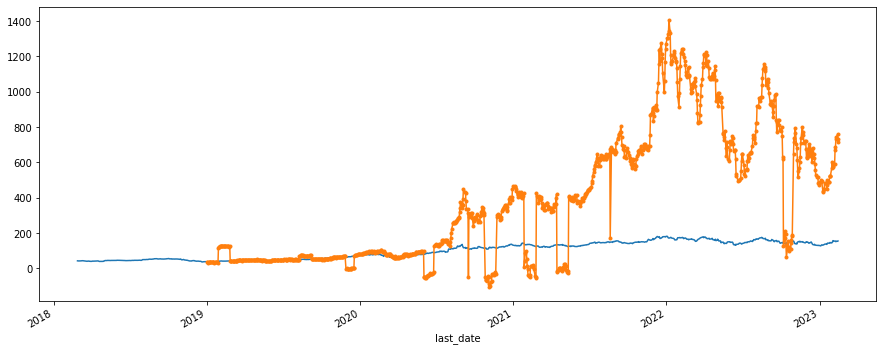

In [45]:
plt.figure(figsize=(15, 6))

y.plot(ax=plt.gca())
y_pred.plot(ax=plt.gca(), legend=None, marker=".")

Well, clearly not perfect ;-)